In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from tqdm import tqdm

from matplotlib import pyplot as plt

from keras.applications import VGG19, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras.callbacks import Callback

from sklearn.metrics import accuracy_score, f1_score


In [3]:
os.chdir('../data')
!pwd

/home/giuliano/git/mo444/lab4/data


In [ ]:
# download data
!wget http://www.recod.ic.unicamp.br/~feandalo/MO444_dogs.tar.gz

# inflate dataset and delete archive
!tar zxf MO444_dogs.tar.gz
!rm MO444_dogs.tar.gz

# Move directories out of MO444_dogs folder and go back to root dir
!mv MO444_dogs/train .
!mv MO444_dogs/test .
!mv MO444_dogs/val .
!rm -rf MO444_dogs

# change directory to the project root
os.chdir('../')
!ls


In [6]:
# Images must be inside class directories for ImageGenerators to work properly
# (According to keras documentation)

def reorganize_dir(path):
    srcfiles = os.listdir(path)

    for filepath in tqdm(srcfiles):
        dest_path = os.path.join(path, '/'.join(filepath.split('_')))
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.move(os.path.join(path, filepath), dest_path)
    
    return

reorganize_dir('data/train')
reorganize_dir('data/val')

100%|██████████| 6024/6024 [00:00<00:00, 30594.34it/s]


## Setting up parameters

In [14]:
##################################
#           PARAMETERS
##################################

# These are some defaults that might change
# according to chosen architecture

img_size = 299 #224
n_classes = 83
batch_size= 32
train_dir = 'data/train/'
test_dir = 'data/test/'
val_dir = 'data/val/'

n_epochs = 25
train_samples = 800
val_samples = 200

In [15]:
def pick_architecture(net_arch):
    net_arch = net_arch.lower()
    params = {}

    if net_arch == 'vgg19':
        img_size = 224
        
        net = VGG19(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3)
        )
        
        params['receptive_field'] = img_size
    elif net_arch == 'inceptionv3':
        # The paper reads:
        # our best models were achieved using RMSProp [21] with decay
        # of 0.9 and epsilon = 1.0. We used a learning rate of 0.045,
        # decayed every two epoch using an exponential rate of 0.94.
        # In addition, gradient clipping [14] with threshold 2.0 was
        # found to be useful to stabilize the training.
        img_size = 299
        
        net = InceptionV3(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3)
        )
        
        params['receptive_field'] = img_size
        params['batch_size'] = 32
        # REMOVED: RMSProp wasn't congerging
        #params['optimizer'] = optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9, clipnorm=2.0)
        
        # TODO: implement the decay each other epoch (like described in the paper).
        # It can be done via keras.callbacks.LearningRateScheduler
        # Source: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
    else:
        print('Invalid architecture name')
    
    return (net, params)


In [ ]:
'''
vggnet = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)
'''
#vggnet.summary()

In [ ]:
'''
inceptionnet = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)
'''
# not a good idea
#inceptionnet.summary()

In [16]:
# net switcher
net, params = pick_architecture('InceptionV3')

net, params

(<keras.engine.training.Model at 0x7fe47f77df98>,
 {'receptive_field': 299, 'batch_size': 32})

In [17]:
# Disable training in all but the last 4 layers
for layer in net.layers:
    layer.trainable = False

# And check it
#for layer in net.layers:
#    print(layer, layer.trainable)


Now I add a few layers for prediction using as output the number of classes in my problem

In [18]:
model = Sequential()

model.add(net)
model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 83)                10879059  
Total params: 32,681,843
Trainable params: 10,879,059
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# I was asked to use as metrics normalised accuracy and F1
# But since 2.0, Keras doesn't support several metrics anymore and the
# reason is sound: they were calculated batchwise instead of globally.
# The answer to this comes with the ability to define Callbacks.

class MetricsCb(Callback):
    def on_train_begin(self, logs={}):
        # define metric histories
        f1_samples = []
        nacc_samples = []
    
    def on_epoch_end(self, epoch, logs={}):
        # calculate metrics for current epoch and update history variables
        validation_preds = (np.asarray(self.model.predict(
            self.validation_data[0]))).round()
        validation_targets = self.validation_data[1]
        
        f1_value = f1_score(validation_targets, validation_preds)
        nacc_value = accuracy_score(validation_targets, validation_preds, normalize=True)
        
        self.f1_samples.append(f1_value)
        self.nacc_samples.append(nacc_value)
        
        print('Custom metrics over epoch %d:\tF1: %.3f\tNormalised Accuracy: %.3f' % (
            epoch, f1_value, nacc_value))

        return

metrics_cb = MetricsCb()


In [19]:
img_size   = params.get('receptive_field') or img_size
batch_size = params.get('batch_size') or batch_size
optimizer  = params.get('optimizer') or optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6)

print(img_size, batch_size, optimizer)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['categorical_accuracy']
)


299 32 <keras.optimizers.SGD object at 0x7fe47d7d7320>


Datagens for image augmentation

In [20]:
# Because net was trained for imagenet, I should normalise the input using:
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
# However, results came even without it, so I am sticking to no normalisation
# until I find it necessary.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)


In [21]:
if (os.getcwd()[-4:] != 'lab4'):
    os.chdir('..')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 8300 images belonging to 83 classes.
Found 6022 images belonging to 83 classes.


In [22]:
# The training, per se
history = model.fit_generator(
    train_generator,
    epochs=n_epochs,
    validation_data=validation_generator,
    #callbacks = [metrics_cb],
    shuffle=True
)


Epoch 1/25
260/260 [==============================] - 200s 771ms/step - loss: 2.0011 - categorical_accuracy: 0.5450 - val_loss: 0.3945 - val_categorical_accuracy: 0.8867
Epoch 2/25
260/260 [==============================] - 188s 724ms/step - loss: 0.8037 - categorical_accuracy: 0.7794 - val_loss: 0.3167 - val_categorical_accuracy: 0.9045
Epoch 3/25
260/260 [==============================] - 189s 726ms/step - loss: 0.6490 - categorical_accuracy: 0.8170 - val_loss: 0.3072 - val_categorical_accuracy: 0.9052
Epoch 4/25
260/260 [==============================] - 190s 729ms/step - loss: 0.5485 - categorical_accuracy: 0.8433 - val_loss: 0.3082 - val_categorical_accuracy: 0.9060
Epoch 5/25
260/260 [==============================] - 188s 722ms/step - loss: 0.4910 - categorical_accuracy: 0.8562 - val_loss: 0.2988 - val_categorical_accuracy: 0.9097
Epoch 6/25
260/260 [==============================] - 188s 725ms/step - loss: 0.4364 - categorical_accuracy: 0.8712 - val_loss: 0.2802 - val_categoric

In [23]:
# Saving model for posteriority
model.save('models/inceptionv3_2.h5')

In [24]:
with open('models/inceptionv3_2.history.npy', 'wb') as f:
    np.save(f, history.history)

## Results (plots)
The first pair of plots are the categorical accuracy and loss (categorical crossentropy) for during training and validation on each epoch

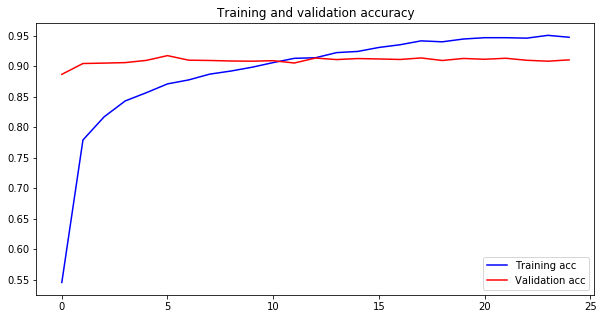

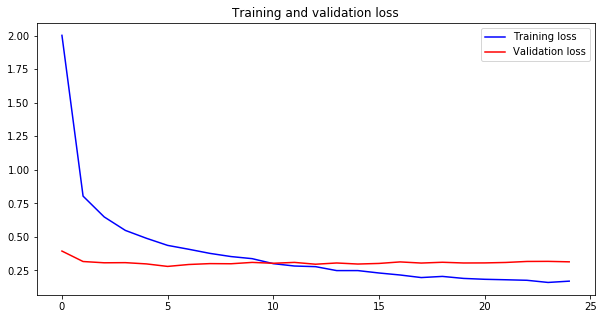

In [25]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

len(acc), len(val_acc)

epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Next we wanna see what are the model's errors

Found 6022 images belonging to 83 classes.
189/188 [==============================] - 39s 204ms/step
errors/all = 539/6022


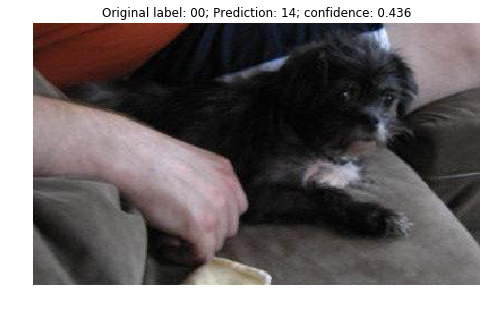

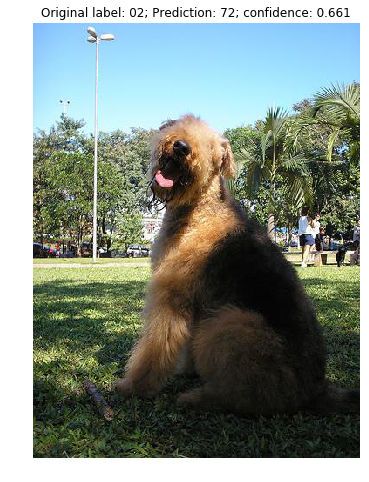

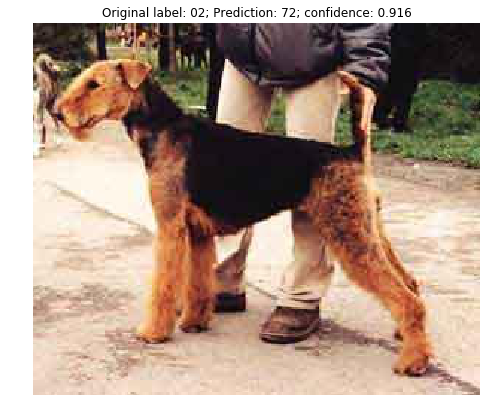

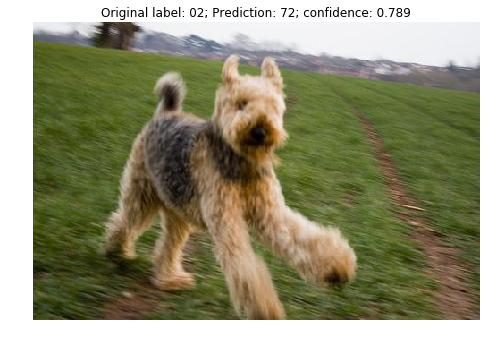

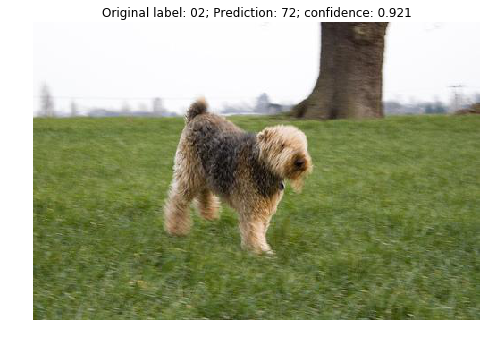

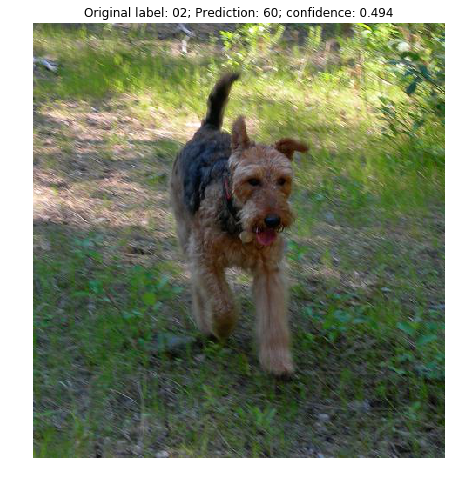

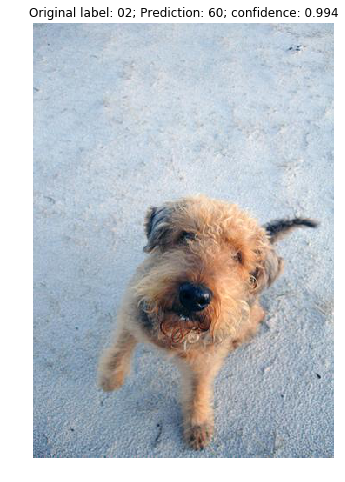

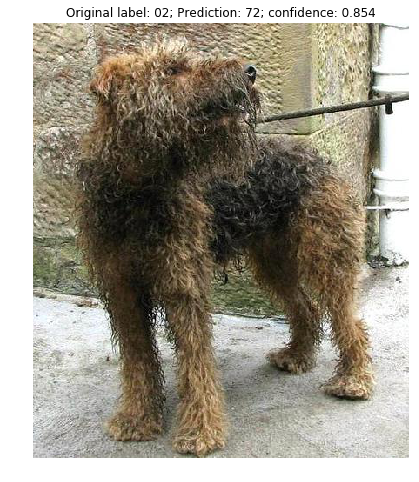

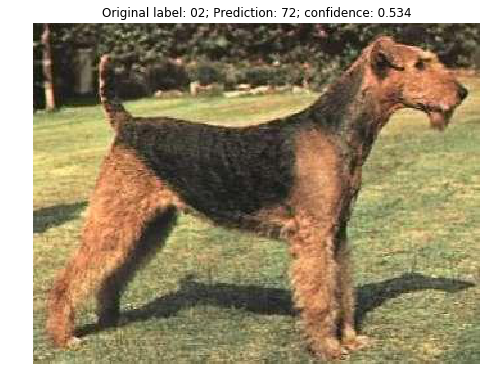

In [26]:
errorcheck_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

filenames = errorcheck_generator.filenames
ground_truth = errorcheck_generator.classes
label2idx = errorcheck_generator.class_indices
idx2label = dict((v, k) for k, v in label2idx.items())

predictions = model.predict_generator(
    errorcheck_generator,
    steps=(validation_generator.samples/validation_generator.batch_size),
    verbose=1
)
predicted_classes = np.argmax(predictions, axis=1)

errors = np.where(predicted_classes != ground_truth)[0]

print('errors/all = %d/%d' % (len(errors), validation_generator.samples))

for i, error in enumerate(errors):
    pred_class = np.argmax(predictions[error])
    pred_label = idx2label[pred_class]
    
    title = 'Original label: %s; Prediction: %s; confidence: %.3f' % (
        filenames[error].split('/')[0],
        pred_label,
        predictions[error][pred_class]
    )
    
    original = plt.imread('%s/%s' % (val_dir, filenames[error]))
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
    
    if i == 8:
        break